In [1]:
import pandas as pd
import numpy as np
import re

import acquire
import prepare
import explore
import model

import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt 


import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import export_graphviz
from sklearn.metrics import recall_score

In [2]:
import pickle
pickle_in = open("dict.pickle","rb")
example_dict = pickle.load(pickle_in)

In [3]:
example_dict

{1: '6', 2: '2', 3: 'f'}

In [4]:
variable_name = open("cucumber.pickle","rb")
cucumber = pickle.load(variable_name)

In [5]:
print(cucumber)

              precision    recall  f1-score   support

           0       0.98      0.99      0.98     63963
           1       0.75      0.54      0.62      3189

    accuracy                           0.97     67152
   macro avg       0.86      0.76      0.80     67152
weighted avg       0.97      0.97      0.97     67152



Use this to drop normalized columns if necessary:


    columns = []
    for i in df.columns:
        columns.append(i)
    columns = str(columns)
    normalized_columns = re.findall(r'(smart_\d+_normalized)', columns)
    df.drop(columns=normalized_columns, inplace=True)"""

In [6]:
df = pd.read_csv('hard_drives_smart_5.csv')

In [7]:
df.shape

(169073, 11)

In [8]:
df.drop(columns=('Unnamed: 0'), inplace = True)

In [9]:
df.columns

Index(['serial_number', 'model', 'capacity_bytes', 'max(failure)',
       'max(smart_9_raw)', 'max(smart_5_raw)', 'max(smart_187_raw)',
       'max(smart_188_raw)', 'max(smart_197_raw)', 'max(smart_198_raw)'],
      dtype='object')

# Prepare

In [10]:
df = prepare.prepare(df)

In [11]:
type(df)

pandas.core.frame.DataFrame

In [12]:
df = prepare.unique(df)

In [13]:
df = prepare.treat_nulls(df)

In [14]:
df.failure.value_counts()

0    155919
1      5911
Name: failure, dtype: int64

In [15]:
df = explore.old_or_fail(df)

In [16]:
df.failure.value_counts()

0    115991
1      5911
Name: failure, dtype: int64

In [17]:
df.head()

,serial_number,manufacturer,model,capacity_terabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4.0,0,5.0,0.0,0.0,0.0,0.0,0.0
1,Z305KB36,Seagate,ST4000DM000,4.0,0,3.5,0.0,0.0,0.0,0.0,0.0
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3.0,0,4.8,0.0,0.0,0.0,0.0,0.0
3,ZA11NHSN,Seagate,ST8000DM002,8.0,0,3.0,0.0,0.0,0.0,0.0,0.0
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3.0,0,5.5,0.0,0.0,0.0,0.0,0.0


# Explore

In [18]:
df = explore.early_failure(df)

In [19]:
df = explore.get_quartile(df)

In [20]:
df = explore.remove_manufacturers(df)

In [21]:
df = explore.make_binary_values(df)

In [22]:
df.head()

,serial_number,manufacturer,model,capacity_terabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count,early_failure,quartile
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4.0,0,5.0,False,False,False,False,False,0,Q4
1,Z305KB36,Seagate,ST4000DM000,4.0,0,3.5,False,False,False,False,False,0,Q3
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3.0,0,4.8,False,False,False,False,False,0,Q4
3,ZA11NHSN,Seagate,ST8000DM002,8.0,0,3.0,False,False,False,False,False,0,Q3
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3.0,0,5.5,False,False,False,False,False,0,Q4


In [23]:
df.failure.value_counts()

0    115989
1      5911
Name: failure, dtype: int64

In [24]:
df.early_failure.value_counts()

0    119302
1      2598
Name: early_failure, dtype: int64

## Manufacturers

- There are 7 different manufacturers
- Seagate and Hitachi make up 97% of all hard drives
- There are 103 unqiue  hard drive models. 43 of these models have less than 10 hard drives. 72 models have less than 100.

In [25]:
df['manufacturer'].nunique()

4

In [26]:
df.shape

(121900, 13)

In [27]:
# How many hard drives per manufacturer?
df['manufacturer'].value_counts()

Seagate            79886
Hitachi            38414
Western Digital     2610
Toshiba              990
Name: manufacturer, dtype: int64

In [28]:
(105136+51417)/162025 *100

96.62274340379571

In [29]:
# How many unique models?
df['model'].nunique()

90

In [30]:
# How many hard drives models with less than 10 hard drives?
(df['model'].value_counts()  < 10).sum()

41

In [31]:
# How many hard drives by individual model?
df['model'].value_counts()

ST4000DM000                35738
HGST HMS5C4040BLE640       15844
ST12000NM0007              14881
ST8000NM0055               14499
ST8000DM002                10041
HGST HMS5C4040ALE640        8617
Hitachi HDS5C3030ALA630     4561
Hitachi HDS722020ALA330     4503
Hitachi HDS5C4040ALE630     2639
ST6000DX000                 1911
ST10000NM0086               1204
WDC WD30EFRX                1083
HGST HUH728080ALE600        1046
Hitachi HDS723030ALA640     1000
ST500LM012 HN                715
TOSHIBA MQ01ABF050           545
WDC WD60EFRX                 471
WDC WD5000LPVX               342
WDC WD10EADS                 295
ST31500541AS                 264
ST4000DX000                  212
TOSHIBA MQ01ABF050M          192
TOSHIBA MD04ABA400V          147
WDC WD1600AAJS               100
HGST HDS5C4040ALE630          94
ST320LT007                    73
WDC WD10EACS                  60
WDC WD5000LPCX                57
ST9250315AS                   56
ST3160316AS                   53
          

In [32]:
# Average drive age by manufacturer
manu = df[['manufacturer', 'drive_age_in_years']]
manu.groupby('manufacturer',sort=True).mean()

,drive_age_in_years
manufacturer,
Hitachi,3.923674
Seagate,3.065102
Toshiba,2.605253
Western Digital,3.997586


### Failures vs. total by model number

In [63]:
agg_model = df.groupby(['model']).agg({'early_failure' : 'sum', 'model' : 'count', 'drive_age_in_years':'mean'})
agg_model.rename(columns={'early_failure':'early_failures', 'model':'total_count'}, inplace=True)

In [64]:
agg_model['early_failure_rate_percent'] = agg_model['early_failures'] / agg_model['total_count'] * 100
agg_model.sort_values(by=['early_failure_rate_percent'], ascending = False)

,early_failures,total_count,drive_age_in_years,early_failure_rate_percent
model,,,,
ST12000NM0117,5,5,0.000000,100.000000
HGST HUH721212ALN604,25,25,0.244000,100.000000
TOSHIBA MG07ACA14TA,11,11,0.200000,100.000000
TOSHIBA HDWF180,1,1,1.300000,100.000000
ST4000DM001,34,34,0.244118,100.000000
ST8000DM004,4,4,0.250000,100.000000
HGST HUH721212ALE600,4,4,0.250000,100.000000
ST500LM030,28,28,0.439286,100.000000
ST4000DX002,3,5,1.020000,60.000000


In [65]:
agg_model.sort_values(by=['total_count'], ascending = False)

,early_failures,total_count,drive_age_in_years,early_failure_rate_percent
model,,,,
ST4000DM000,753,35738,3.907723,2.107001
HGST HMS5C4040BLE640,129,15844,3.189504,0.814188
ST12000NM0007,963,14881,1.763920,6.471339
ST8000NM0055,270,14499,2.231747,1.862197
ST8000DM002,171,10041,3.008097,1.703018
HGST HMS5C4040ALE640,23,8617,3.698445,0.266914
Hitachi HDS5C3030ALA630,0,4561,5.046196,0.000000
Hitachi HDS722020ALA330,0,4503,5.447746,0.000000
Hitachi HDS5C4040ALE630,0,2639,4.831982,0.000000


In [72]:
agg_model

,early_failures,total_count,drive_age_in_years,early_failure_rate_percent
model,,,,
HGST HDS5C4040ALE630,2,94,2.856383,2.127660
HGST HDS724040ALE640,0,40,4.015000,0.000000
HGST HMS5C4040ALE640,23,8617,3.698445,0.266914
HGST HMS5C4040BLE640,129,15844,3.189504,0.814188
HGST HUH721212ALE600,4,4,0.250000,100.000000
HGST HUH721212ALN604,25,25,0.244000,100.000000
HGST HUH728080ALE600,11,1046,1.981549,1.051625
HGST HUS726040ALE610,2,19,2.126316,10.526316
Hitachi HDS5C3030ALA630,0,4561,5.046196,0.000000


> When aggregating by model number, we see wide variance in hard drive age and early failure rates. 

Text(0.5, 1.0, 'Early Failure Rates by Model')

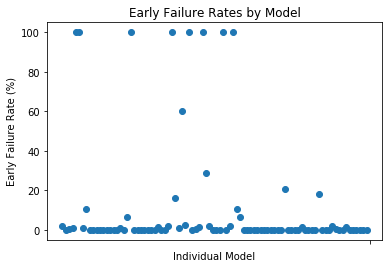

In [70]:
plt.scatter(agg_model.index, agg_model.early_failure_rate_percent)
plt.xticks('')
plt.xlabel('Individual Model')
plt.ylabel('Early Failure Rate (%)')
plt.title('Early Failure Rates by Model')

In [68]:
agg_model [agg_model.total_count > 100].sort_values('early_failure_rate_percent')

,early_failures,total_count,drive_age_in_years,early_failure_rate_percent
model,,,,
WDC WD10EADS,0,295,6.154576,0.000000
Hitachi HDS5C3030ALA630,0,4561,5.046196,0.000000
Hitachi HDS5C4040ALE630,0,2639,4.831982,0.000000
Hitachi HDS722020ALA330,0,4503,5.447746,0.000000
Hitachi HDS723030ALA640,0,1000,5.384900,0.000000
TOSHIBA MD04ABA400V,0,147,4.258503,0.000000
ST31500541AS,0,264,5.986364,0.000000
HGST HMS5C4040ALE640,23,8617,3.698445,0.266914
WDC WD5000LPVX,2,342,4.132456,0.584795


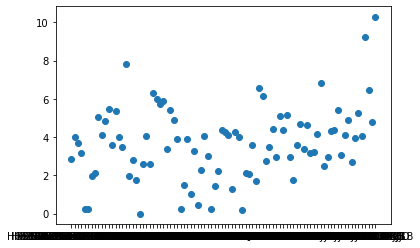

In [37]:
plt.scatter(x=agg_model.index, y=agg_model.drive_age_in_years)

AttributeError: module 'matplotlib.pyplot' has no attribute 'y_axis'

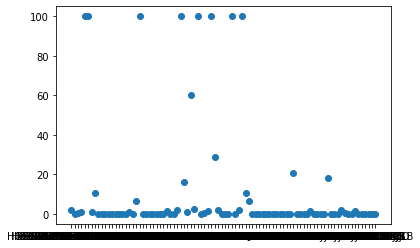

In [69]:
plt.scatter(x=agg_model.index, y=agg_model.early_failure_rate_percent)

In [39]:
#failures = df[df.failure == 1]
#non_failures = df[df.failure == 0]

In [40]:
(df.model.value_counts() > 50).sum()

30

In [41]:
df.model.nunique()

90

In [42]:
df.shape

(121900, 13)

In [43]:
train, test = train_test_split(df,train_size =.80, random_state = 123)

In [44]:
train.shape


(97520, 13)

In [45]:
test.shape

(24380, 13)

### Aggregation by Manufacturer

In [46]:
# 6 unique manufacturers
df.manufacturer.unique()

array(['Hitachi', 'Seagate', 'Western Digital', 'Toshiba'], dtype=object)

In [47]:
manufacturers = df.groupby(['manufacturer']).agg({'early_failure' : 'sum', 'manufacturer' : 'count', 'drive_age_in_years':'mean'})
manufacturers.rename(columns={'early_failure':'early_failures', 'manufacturer':'total_count'}, inplace=True)

In [48]:
manufacturers['early_failure_rate_percent'] = manufacturers['early_failures'] / manufacturers['total_count'] * 100
manufacturers.sort_values(by=['early_failure_rate_percent'], ascending = False)

,early_failures,total_count,drive_age_in_years,early_failure_rate_percent
manufacturer,,,,
Toshiba,84,990,2.605253,8.484848
Seagate,2282,79886,3.065102,2.856571
Western Digital,36,2610,3.997586,1.379310
Hitachi,196,38414,3.923674,0.510231


([0, 1, 2, 3], <a list of 4 Text xticklabel objects>)

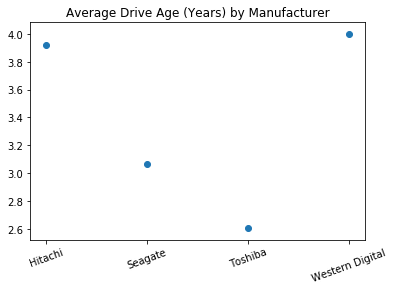

In [49]:
plt.scatter(x=manufacturers.index, y=manufacturers.drive_age_in_years)
plt.title('Average Drive Age (Years) by Manufacturer')
plt.xticks(rotation=20)

([0, 1, 2, 3], <a list of 4 Text xticklabel objects>)

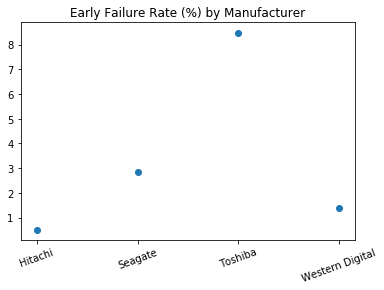

In [50]:
plt.scatter(x=manufacturers.index, y=manufacturers.early_failure_rate_percent)
plt.title('Early Failure Rate (%) by Manufacturer')
plt.xticks(rotation=20)

# Model

In [51]:
df.head()

,serial_number,manufacturer,model,capacity_terabytes,failure,drive_age_in_years,reallocated_sectors_count,reported_uncorrectable_errors,command_timeout,current_pending_sector_count,uncorrectable_sector_count,early_failure,quartile
0,PL1311LAG1SJAA,Hitachi,Hitachi HDS5C4040ALE630,4.0,0,5.0,False,False,False,False,False,0,Q4
1,Z305KB36,Seagate,ST4000DM000,4.0,0,3.5,False,False,False,False,False,0,Q3
2,MJ0351YNG9MZXA,Hitachi,Hitachi HDS5C3030ALA630,3.0,0,4.8,False,False,False,False,False,0,Q4
3,ZA11NHSN,Seagate,ST8000DM002,8.0,0,3.0,False,False,False,False,False,0,Q3
4,MJ1311YNG2ZSEA,Hitachi,Hitachi HDS5C3030ALA630,3.0,0,5.5,False,False,False,False,False,0,Q4


### Split data

In [52]:
# Split data
X_train, X_test, y_train, y_test = model.split_my_data(df)

In [53]:
# drop non numeric columns
X_train.drop(columns={'serial_number','model','quartile','drive_age_in_years','reallocated_sectors_count','reported_uncorrectable_errors','command_timeout','current_pending_sector_count','uncorrectable_sector_count'}, inplace = True)
X_test.drop(columns={'serial_number','model','quartile','drive_age_in_years','reallocated_sectors_count','reported_uncorrectable_errors','command_timeout','current_pending_sector_count','uncorrectable_sector_count'}, inplace = True)

KeyError: "['drive_age_in_years'] not found in axis"

In [ ]:
X_train.columns

### One hote encode manufacturer column

In [ ]:
X_train, X_test = model.encode_hot(X_train, X_test, 'manufacturer')

In [ ]:
X_train.drop(columns='manufacturer', inplace = True)
X_test.drop(columns='manufacturer', inplace = True)

### Run a loop of models

In [ ]:
k_range = range(2, 12)
scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k, weights = 'distance')
    knn.fit(X_train, y_train)
    train_pred=knn.predict(X_train)
    scores.append(recall_score(y_train, train_pred))

In [ ]:
plt.figure()
plt.xlabel('K Value')
plt.ylabel('Recall')
plt.scatter(k_range, scores)
plt.xticks([2,4,6,8,10,12])
plt.title('Recall for different K values')

In [ ]:
confusion_matrix(y_train,train_pred)

In [ ]:
print(f'The best recall is at k= {scores.index(max(scores))+(min(k_range))} with a recall score of {max(scores)}')

### Run one model

In [ ]:
score = []
n_neighbors = 3
knn = KNeighborsClassifier(n_neighbors, weights = 'uniform')
knn.fit(X_train, y_train)
train_pred=knn.predict(X_train)
score.append(recall_score(y_train, train_pred))

In [ ]:
plt.figure()
plt.xlabel('K Value')
plt.ylabel('Recall')
plt.scatter(n_neighbors, score)
plt.title(f'Recall for  K ={n_neighbors}')
print(confusion_matrix(y_train,train_pred))
print(f'The best recall is at k= {score.index(max(score))} with a recall score of {max(score)}')

In [ ]:
df.early_failure.value_counts()

In [ ]:
2598/(2598+119302) *100

In [ ]:
df.failure.value_counts()

In [ ]:
X_train.columns